## Quantitative trading in China A stock market with FinRL

### Import modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython import display
display.set_matplotlib_formats("svg")

from finrl_meta import config
from finrl_meta.data_processors.processor_tusharepro import TushareProProcessor, ReturnPlotter
from finrl_meta.env_stock_trading.env_stocktrading_A import StockTradingEnv
from drl_agents.stablebaselines3_models import DRLAgent
pd.options.display.max_columns = None
    
print("ALL Modules have been imported!")

ALL Modules have been imported!


### Create folders

In [2]:
import os
if not os.path.exists("./datasets" ):
    os.makedirs("./datasets" )
if not os.path.exists("./trained_models"):
    os.makedirs("./trained_models" )
if not os.path.exists("./tensorboard_log"):
    os.makedirs("./tensorboard_log" )
if not os.path.exists("./results" ):
    os.makedirs("./results" )
    
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### Download data, cleaning and feature engineering

In [3]:
ticket_list=['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH',
       '600031.SH', '600036.SH', '600050.SH', '600104.SH', '600196.SH',
       '600276.SH', '600309.SH', '600519.SH', '600547.SH', '600570.SH']

train_start_date='2015-01-01'
train_stop_date='2019-08-01'
val_start_date='2019-08-01'
val_stop_date='2021-01-03'

token='27080ec403c0218f96f388bca1b1d85329d563c91a43672239619ef5'

In [4]:
# download and clean
ts_processor = TushareProProcessor("tusharepro", token=token)
ts_processor.download_data(ticket_list, train_start_date, val_stop_date, "1D")
ts_processor.clean_data()
ts_processor.dataframe

100%|██████████████████████████████████████████| 15/15 [00:10<00:00,  1.50it/s]


Shape of DataFrame:  (21574, 8)
Shape of DataFrame:  (21930, 8)


,tic,date,open,high,low,close,volume,day
0,600000.SH,2015-01-05,15.88,16.25,15.56,16.07,5135687.09,0.0
1,600009.SH,2015-01-05,19.82,20.91,19.82,20.53,371485.54,0.0
2,600016.SH,2015-01-05,10.87,10.96,10.50,10.78,9138873.70,0.0
3,600028.SH,2015-01-05,6.59,7.14,6.45,7.14,11864996.45,0.0
4,600030.SH,2015-01-05,33.90,35.25,33.01,34.66,6986272.15,0.0
...,...,...,...,...,...,...,...,...
21925,600276.SH,2020-12-31,112.55,112.66,110.01,111.46,281568.85,3.0
21926,600309.SH,2020-12-31,89.88,91.48,88.70,91.04,213631.34,3.0
21927,600519.SH,2020-12-31,1941.00,1998.98,1939.00,1998.00,38860.07,3.0
21928,600547.SH,2020-12-31,23.60,23.75,23.48,23.62,213786.94,3.0


In [5]:
# add_technical_indicator
ts_processor.add_technical_indicator(config.TECHNICAL_INDICATORS_LIST)
ts_processor.clean_data()
ts_processor.dataframe

Succesfully add technical indicators
Shape of DataFrame:  (21885, 16)


,tic,date,index,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,dx_30,close_30_sma,close_60_sma
0,600000.SH,2015-01-08,45,15.87,15.88,15.20,15.25,3306271.72,3.0,-0.032571,16.617911,15.012089,6.058641,23.014040,15.815000,15.815000
1,600009.SH,2015-01-08,46,20.18,20.18,19.73,20.00,198117.45,3.0,-0.016008,20.663897,19.736103,12.828915,100.000000,20.200000,20.200000
2,600016.SH,2015-01-08,47,10.61,10.66,10.09,10.20,4851684.17,3.0,-0.018247,10.957604,9.997396,11.862558,100.000000,10.477500,10.477500
3,600028.SH,2015-01-08,48,7.09,7.41,6.83,6.85,8190902.35,3.0,-0.008227,7.342000,6.743000,27.409248,64.934862,7.042500,7.042500
4,600030.SH,2015-01-08,49,36.40,36.70,34.68,35.25,6376268.69,3.0,0.032910,36.576444,33.808556,61.517448,100.000000,35.192500,35.192500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21880,600276.SH,2020-12-31,21925,112.55,112.66,110.01,111.46,281568.85,3.0,5.999563,120.049291,81.980709,65.497668,49.657169,96.356667,92.992167
21881,600309.SH,2020-12-31,21926,89.88,91.48,88.70,91.04,213631.34,3.0,1.723646,92.780907,79.425093,58.501768,38.129756,85.693000,84.104667
21882,600519.SH,2020-12-31,21927,1941.00,1998.98,1939.00,1998.00,38860.07,3.0,42.535547,1942.989267,1761.052733,66.422960,52.684229,1815.039333,1761.921500
21883,600547.SH,2020-12-31,21928,23.60,23.75,23.48,23.62,213786.94,3.0,-0.252554,24.495355,23.032645,42.060734,0.003164,23.883667,24.534000


### Split traning dataset

In [6]:
train =ts_processor.data_split(ts_processor.dataframe, train_start_date, train_stop_date)       
len(train.tic.unique())

15

In [7]:
train.tic.unique()

array(['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH',
       '600031.SH', '600036.SH', '600050.SH', '600104.SH', '600196.SH',
       '600276.SH', '600309.SH', '600519.SH', '600547.SH', '600570.SH'],
      dtype=object)

In [8]:
train.head()

,tic,date,index,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,dx_30,close_30_sma,close_60_sma
0,600000.SH,2015-01-08,45,15.87,15.88,15.20,15.25,3306271.72,3.0,-0.032571,16.617911,15.012089,6.058641,23.014040,15.8150,15.8150
0,600009.SH,2015-01-08,46,20.18,20.18,19.73,20.00,198117.45,3.0,-0.016008,20.663897,19.736103,12.828915,100.000000,20.2000,20.2000
0,600016.SH,2015-01-08,47,10.61,10.66,10.09,10.20,4851684.17,3.0,-0.018247,10.957604,9.997396,11.862558,100.000000,10.4775,10.4775
0,600028.SH,2015-01-08,48,7.09,7.41,6.83,6.85,8190902.35,3.0,-0.008227,7.342000,6.743000,27.409248,64.934862,7.0425,7.0425
0,600030.SH,2015-01-08,49,36.40,36.70,34.68,35.25,6376268.69,3.0,0.032910,36.576444,33.808556,61.517448,100.000000,35.1925,35.1925


In [9]:
train.shape

(16695, 16)

In [10]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension*(len(config.TECHNICAL_INDICATORS_LIST)+2)+1
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 15, State Space: 136


### Train

In [11]:
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1000000, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":1.0687e-3,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "print_verbosity": 1,
    "initial_buy":True,
    "hundred_each_trade":True
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [12]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [13]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
                "batch_size": 256, 
               "buffer_size": 50000, 
               "learning_rate": 0.0005,
               "action_noise":"normal",
                }
POLICY_KWARGS = dict(net_arch=dict(pi=[64, 64], qf=[400, 300]))
model_ddpg = agent.get_model("ddpg", model_kwargs = DDPG_PARAMS, policy_kwargs=POLICY_KWARGS)

{'batch_size': 256, 'buffer_size': 50000, 'learning_rate': 0.0005, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device


In [14]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                              tb_log_name='ddpg',
                              total_timesteps=1000)


Logging to tensorboard_log/ddpg\ddpg_34
Episode: 2
day: 1112, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 3594165.32
total_reward: 2594165.32
total_cost: 12535.83
total_trades: 16680
Sharpe: 1.192


### Trade

In [15]:
trade = ts_processor.data_split(ts_processor.dataframe, val_start_date, val_stop_date)
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1000000, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":1.0687e-3,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "print_verbosity": 1,
    "initial_buy":False,
    "hundred_each_trade":True
}
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [16]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,
                       environment = e_trade_gym)

Episode: 2
day: 345, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1893034.29
total_reward: 893034.29
total_cost: 893.71
total_trades: 1386
Sharpe: 1.619
hit end!


In [17]:
df_actions.to_csv("action.csv",index=False)
df_actions

,600000.SH,600009.SH,600016.SH,600028.SH,600030.SH,600031.SH,600036.SH,600050.SH,600104.SH,600196.SH,600276.SH,600309.SH,600519.SH,600547.SH,600570.SH
date,,,,,,,,,,,,,,,
2019-08-01,0,1000,1000,1000,0,0,0,0,0,0,0,1000,0,0,0
2019-08-02,0,1000,1000,1000,0,0,0,0,0,0,0,1000,0,0,0
2019-08-05,0,1000,1000,1000,0,0,0,0,0,0,0,1000,0,0,0
2019-08-06,0,1000,1000,1000,0,0,0,0,0,0,0,1000,0,0,0
2019-08-07,0,1000,1000,1000,0,0,0,0,0,0,0,1000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Backtest

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


ValueError: x and y must have same first dimension, but have shapes (346,) and (339,)

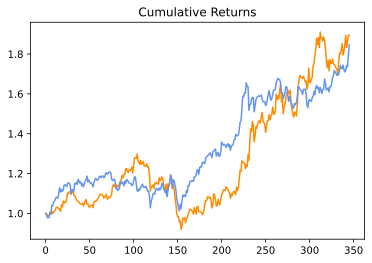

In [18]:
%matplotlib inline
plotter = ReturnPlotter(df_account_value, trade, val_start_date, val_stop_date)
plotter.plot_all()

In [ ]:
%matplotlib inline
plotter.plot()

In [ ]:
%matplotlib inline
# ticket: SSE 50：000016
plotter.plot("000016")

#### Use pyfolio

In [ ]:
# CSI 300
baseline_df = plotter.get_baseline("399300")

In [ ]:
import pyfolio
from pyfolio import timeseries
daily_return = plotter.get_return(df_account_value)
daily_return_base = plotter.get_return(baseline_df, value_col_name="close")

perf_func = timeseries.perf_stats
perf_stats_all = perf_func(returns=daily_return, 
                              factor_returns=daily_return_base, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============DRL Strategy Stats===========")
perf_stats_all

In [ ]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = daily_return,
                                       benchmark_rets = daily_return_base, set_context=False)

### Authors
github username: oliverwang15, eitin-infant